# Some function definitions

In [1]:
import h5py
import numpy as np

def write_ndarray_to_hdf5(file_path: str, ndarray: np.ndarray) -> None:
    hdf5_file = h5py.File(file_path, 'w')
    hdf5_file.create_dataset('dataset', data=ndarray)
    hdf5_file.close()


def read_ndarray_from_hdf5(file_path: str) -> np.ndarray:
    hdf5_file = h5py.File(file_path, 'r')
    data = hdf5_file.get('dataset')
    return np.array(data)


In [2]:
from typing import Tuple, Iterable

from matplotlib import pyplot as plt

DEFAULT_PLOT_SIZE = (20, 2.5)


def display_channels(tensor: np.ndarray, variable_names: Iterable, plot_size: Tuple[float, float], title: str) -> None :
  reshaped_tensor = tensor.swapaxes(0,2) # Brings back the channels from the last dimension to the first.
  reshaped_tensor = reshaped_tensor.swapaxes(1,2) # Set the latitude as vertical axis.
  plt.figure(figsize=plot_size)
  nb_channel = tensor.shape[-1]
  for channel_id in range(0, nb_channel):
    channel = reshaped_tensor[channel_id]
    plt.subplot(1, nb_channel, (channel_id+1))
    plt.title(variable_names[channel_id], {'fontsize': 14})
    # Remove ticks from the x and y axes
    plt.xticks([])
    plt.yticks([])
    plt.imshow(channel, cmap='gist_rainbow_r', interpolation="none")
  plt.suptitle(title, fontsize=16, va='bottom')
  plt.show()

In [3]:
import math

def generate_float_range(start, stop, resolution):
    if resolution < 1:
        nb_decimal = len(str(resolution)) - 2  # -2 for the zero and the dot.
        factor = math.pow(10, nb_decimal)
        int_range = range(int(start*factor), int(stop*factor), int(resolution*factor))
        result = list()
        for value in int_range:
            result.append(value/100)
        return result
    else:
        return range(start, stop, resolution)


def generate_mapping_degrees_east_m_180_to_0(resolution):
    dest_values = generate_float_range(0, 360, resolution)
    keys_1 = generate_float_range(0, (180 + resolution), resolution)
    keys_2 = generate_float_range((-180 + resolution), 0, resolution)
    result = dict()
    index = 0
    for key in keys_1:
        result[key] = dest_values[index]
        index = index + 1
    for key in keys_2:
        result[key] = dest_values[index]
        index = index + 1
    return result


def round_nearest(value, resolution, num_decimal):
    return round(round(value / resolution) * resolution, num_decimal)


ERA5_LON_RESOLUTION = 0.25
ERA5_LON_NUM_DECIMAL = 2
ERA5_LON_MAPPING = generate_mapping_degrees_east_m_180_to_0(ERA5_LON_RESOLUTION)


def translate_lon_coordinate(lon: float) -> float:
    rounded_lon = round_nearest(lon, ERA5_LON_RESOLUTION, ERA5_LON_NUM_DECIMAL)
    return ERA5_LON_MAPPING[rounded_lon]

# Comparing ERA5 and MERRA-2 cyclone plots
## Loading the dataset

In [4]:
import os.path as path
import pandas as pd

merra2_root_dir = '/home_local/sgardoll/tmp_cyclone'

merra2_variable_names = ('slp', 'tqv', 'u10m', 'v10m', 't200', 't500', 'u850', 'v850')

merra2_tensor_file_path = path.join(merra2_root_dir, 'tensors', 'training_2010_data.h5')
merra2_tensor = read_ndarray_from_hdf5(file_path=merra2_tensor_file_path)
# the order of the ERA5 latitudes is from North to South whereas the order of MERRA-2 latitudes is from South to North. 
merra2_tensor = np.fliplr(merra2_tensor) 
merra2_metadata_file_path = path.join(merra2_root_dir, 'tensors', 'training_2010_metadata.csv')
merra2_metadata = pd.read_csv(merra2_metadata_file_path)

era5_root_dir = '/home_local/sgardoll/tmp_cyclone'

era5_variable_names = ('msl', 'tcwv', 'u10', 'v10', 't200', 't500', 'u850', 'v850')

era5_training_tensor_file_path = path.join(era5_root_dir, 'tensors', 'training_all_data.h5')
era5_training_tensor = read_ndarray_from_hdf5(file_path=era5_training_tensor_file_path)
era5_training_metadata_file_path = path.join(era5_root_dir, 'tensors', 'training_all_metadata.csv')
era5_training_metadata = pd.read_csv(era5_training_metadata_file_path)

era5_test_tensor_file_path = path.join(era5_root_dir, 'tensors', 'test_all_data.h5')
era5_test_tensor = read_ndarray_from_hdf5(file_path=era5_test_tensor_file_path)
era5_test_metadata_file_path = path.join(era5_root_dir, 'tensors', 'test_all_metadata.csv')
era5_test_metadata = pd.read_csv(era5_test_metadata_file_path)

## Computing MERRA-2's lon into 0-360

In [5]:
merra2_metadata.rename(columns = {'lon':'lon_180'}, inplace=True)
merra2_metadata['lon'] = merra2_metadata['lon_180'].apply(func=translate_lon_coordinate)

## ERA5 and MERRA-2 plots

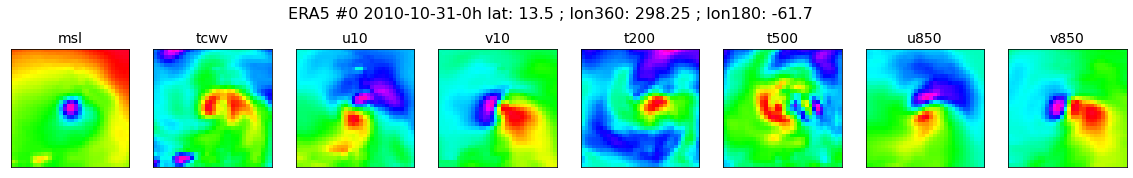

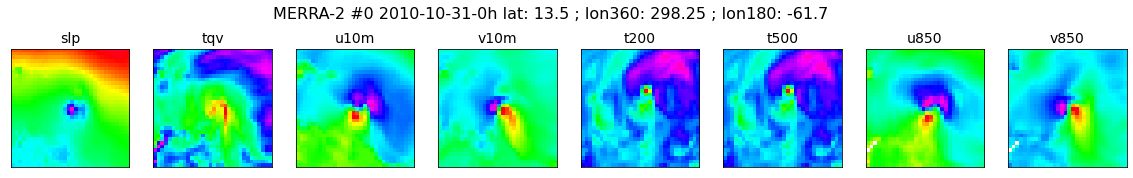

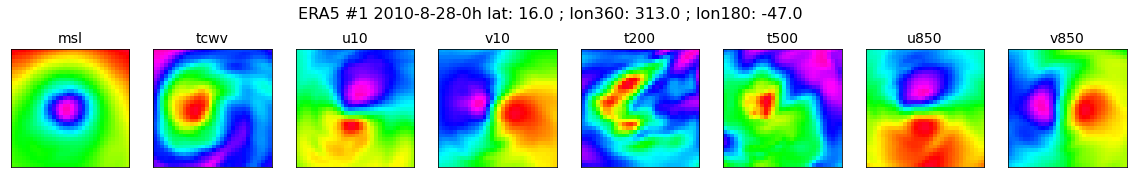

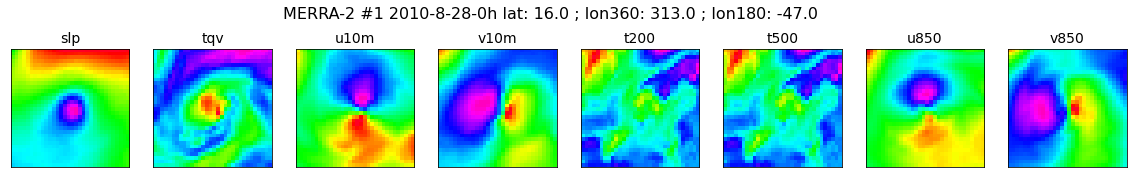

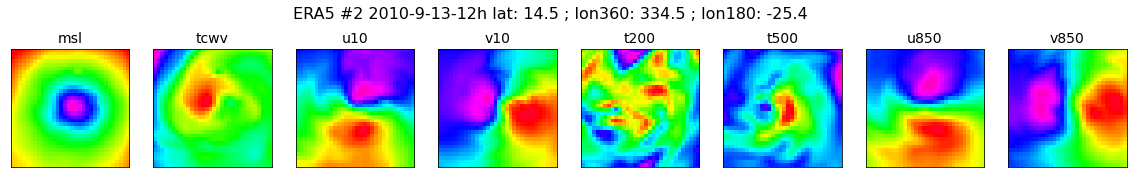

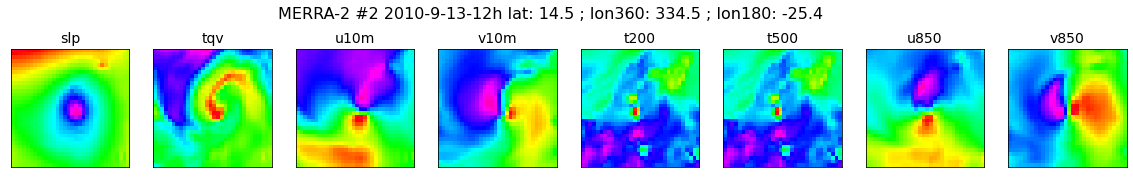

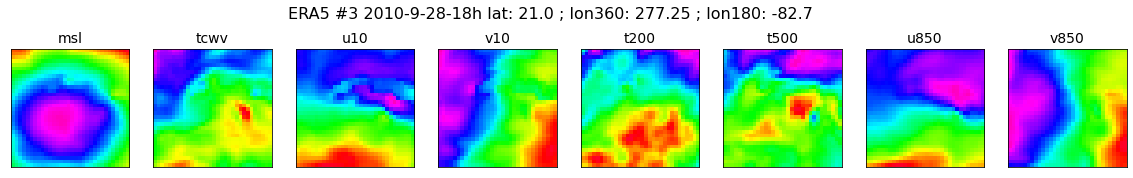

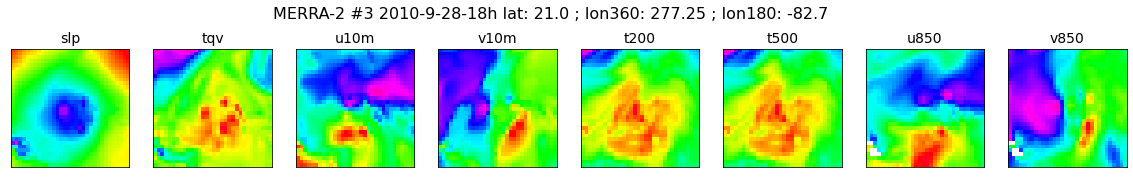

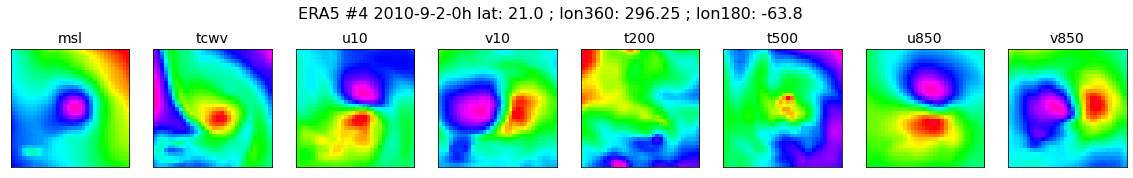

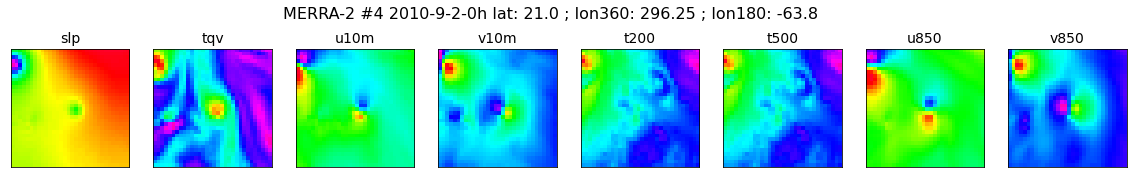

In [6]:
max_img = 5
plot_size = (20, 2.5)

# Adding the index as a new column.
era5_training_metadata['era5_index'] = era5_training_metadata.index 
merra2_metadata['merra2_index'] = merra2_metadata.index

# Select cyclones.
merra2_cyclone_metadata = merra2_metadata.loc[merra2_metadata['label_num_id'] > 0.]
# Compute the intersection between the two metadata set.
intersection = pd.merge(era5_training_metadata, merra2_cyclone_metadata, how='inner', indicator=True, on=['year', 'month', 'day', 'hour', 'lat', 'lon']).head(max_img)

for index, row in intersection.iterrows():
    coordinates = f"{row['year']}-{row['month']}-{row['day']}-{row['hour']}h lat: {row['lat']} ; lon360: {row['lon']} ; lon180: {row['lon_180']}"
    display_channels(era5_training_tensor[row['era5_index']], era5_variable_names, plot_size, f'ERA5 #{index} {coordinates}')
    display_channels(merra2_tensor[row['merra2_index']], merra2_variable_names, plot_size, f'MERRA-2 #{index} {coordinates}')

# ERA5 model performance evaluation

Trained on ERA5 dataset, prediction on MERRA-2 2010 dataset and ERA5 test dataset.

## Model loading

In [7]:
import keras

def load_model(neural_network_weights_file_path: str) -> keras.models.Model:
  print(f'> loading model {neural_network_weights_file_path}')
  return keras.models.load_model(neural_network_weights_file_path)


In [8]:
neural_network_weights_file_path = path.join(merra2_root_dir, 'models', 'best_all_model_06_23_2020_09-35-03.h5')
era5_model = load_model(neural_network_weights_file_path)
mera2_predicted_probs = era5_model.predict(merra2_tensor)
era5_predicted_probs = era5_model.predict(era5_test_tensor)
# Convert the probabilities into the class based on the higher probability.
# Class 0 for no cyclone, 1 for cyclone.
threshold_probability = 0.5
merra2_predicted_class = np.where(mera2_predicted_probs > threshold_probability, 1, 0)
era5_predicted_class = np.where(era5_predicted_probs > threshold_probability, 1, 0)

> loading model /home_local/sgardoll/tmp_cyclone/models/best_all_model_06_23_2020_09-35-03.h5


In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## ROC scoring

In [10]:
auc_model = roc_auc_score(y_true=merra2_metadata['label_num_id'], y_score=mera2_predicted_probs)
print(f'  > roc of ERA5 model on MERRA-2 dataset = {auc_model}')

  > roc of ERA5 model on MERRA-2 dataset = 0.9826146076146077


In [11]:
auc_model = roc_auc_score(y_true=era5_test_metadata['label_num_id'], y_score=era5_predicted_probs)
print(f'  > roc of ERA5 model on ERA5 test dataset = {auc_model}')

  > roc of ERA5 model on ERA5 test dataset = 0.9982558761342977


## Classification report

In [12]:
print('  > the classification report of ERA5 model on MERRA-2 dataset:')
print(classification_report(y_true=merra2_metadata['label_num_id'], y_pred=merra2_predicted_class, target_names=['no_cyclones', 'cyclones']))

  > the classification report of ERA5 model on MERRA-2 dataset:
              precision    recall  f1-score   support

 no_cyclones       0.94      0.98      0.96       702
    cyclones       0.95      0.87      0.91       352

    accuracy                           0.94      1054
   macro avg       0.94      0.92      0.93      1054
weighted avg       0.94      0.94      0.94      1054



In [13]:
print('  > the classification report of ERA5 model on ERA5 test dataset:')
print(classification_report(y_true=era5_test_metadata['label_num_id'], y_pred=era5_predicted_class, target_names=['no_cyclones', 'cyclones']))

  > the classification report of ERA5 model on ERA5 test dataset:
              precision    recall  f1-score   support

 no_cyclones       0.98      0.99      0.99      3921
    cyclones       0.98      0.97      0.97      1984

    accuracy                           0.98      5905
   macro avg       0.98      0.98      0.98      5905
weighted avg       0.98      0.98      0.98      5905



## Model accuracy

In [14]:
print('> evaluating the ERA5 model on MERRA-2 dataset')
loss_value, metric_value = era5_model.evaluate(x=merra2_tensor, y=merra2_metadata['label_num_id'], verbose=0)
print(f'  > loss = {loss_value}')
print(f'  > metric = {metric_value}')

> evaluating the ERA5 model on MERRA-2 dataset
  > loss = 0.21959486603736877
  > metric = 0.9411764740943909


In [15]:
print('> evaluating the ERA5 model on ERA5 test dataset')
loss_value, metric_value = era5_model.evaluate(x=era5_test_tensor, y=era5_test_metadata['label_num_id'], verbose=0)
print(f'  > loss = {loss_value}')
print(f'  > metric = {metric_value}')

> evaluating the ERA5 model on ERA5 test dataset
  > loss = 0.048071421682834625
  > metric = 0.9820491075515747


## Dummy classifier

In [16]:
from sklearn.dummy import DummyClassifier

dummy_strategies = (('stratified', None), ('most_frequent', None), ('prior', None), ('uniform', None), ('constant', 0.))

print('> training and evaluating dummy classifiers on ERA5 dataset')
for strategy, constant in dummy_strategies:
    dummy_model = DummyClassifier(strategy=strategy, constant=constant, random_state=0)
    dummy_model.fit(era5_training_tensor, era5_training_metadata['label_num_id'])
    accuracy = dummy_model.score(era5_test_tensor, era5_test_metadata['label_num_id'])
    print(f'  > accuracy is {accuracy} using strategy {strategy}')

> training and evaluating dummy classifiers on ERA5 dataset
  > accuracy is 0.5554614733276884 using strategy stratified
  > accuracy is 0.6640135478408129 using strategy most_frequent
  > accuracy is 0.6640135478408129 using strategy prior
  > accuracy is 0.49483488569009315 using strategy uniform
  > accuracy is 0.6640135478408129 using strategy constant
